[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/AI-og-helse/blob/main/uke08-etikk-implementering/02_bias_rettferdighet.ipynb)

# ⚖️ Bias og Rettferdighet i AI-systemer

> **"Algorithms are opinions embedded in code"**  / **"An algorithm is not a fact. It's an opinion embedded in math"** - Cathy O'Neil <br>
>  (amerikansk matematiker og forfatter, kjent for boken _Weapons of Math Destruction_, 2016)

Velkommen til kanskje den mest kritiske dagen i AI-etikk. Vi skal utforske hvordan tilsynelatende "objektive" algoritmer kan diskriminere, og viktigst av alt - hvordan vi kan avverge dem.

## �� Hva du lærer i dag?

✅ Identifisere skjulte bias i "objektive" datasett  
✅ Forstå ulike typer bias (historisk, representasjons-, måle-, algoritmisk)  
✅ Mestre fairness-metrikker som demografisk paritet og equalized odds  
✅ Implementere bias-deteksjon og fairness-evaluering  
✅ Anvende pre-, in- og post-processing teknikker for bias-reduksjon  
✅ Balansere nøyaktighet og rettferdighet i praksis  

**💡 Sjokkerende fakta:** Amazon utviklet et AI-rekrutteringsverktøy som systematisk diskriminerte mot kvinner ved å straffe CV-er som inneholdt ordet "kvinner" og nedgradere ferdighetene til kvinnelige nyutdannede. Til tross for forsøk på å fikse algoritmen, måtte Amazon droppe verktøyet helt i 2018!

> "Amazon's AI recruiting tool showed bias against women" - Reuters, 2018 [[link](https://www.reuters.com/article/us-amazon-com-jobs-automation-insight-idUSKCN1MK08G/)]

### Men først: 🔧 miljøoppsett - kode skal fungere både lokalt, i Codespaces samt Google Colab

In [90]:
import sys
import subprocess
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Kjører i Google Colab")
    
    # Installer nødvendige pakker som ikke er forhåndsinstallert i Colab
    !pip install seaborn --quiet
    
    # Sjekk om mappen allerede eksisterer
    if not os.path.exists('AI-og-helse'):
        print("📥 Laster ned kursmateriell...")
        try:
            # Prøv å klone repositoryet (da være public)
            !git clone https://github.com/arvidl/AI-og-helse.git
            print("✅ Repository klonet vellykket!")
        except:
            print("⚠️ Kunne ikke klone repository automatisk")
            print("💡 Du kan laste opp filer manuelt eller bruke en annen metode")
    
    # Bytt til riktig mappe hvis den eksisterer
    if os.path.exists('AI-og-helse'):
        os.chdir('AI-og-helse')
        print(f"📁 Byttet til mappe: {os.getcwd()}")
    else:
        print("📂 Arbeider i standard Colab-mappe")
        
else:
    print("💻 Kjører i lokal miljø/Codespaces")

# Standard imports som fungerer overalt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Miljø er konfigurert og klart!")

💻 Kjører i lokal miljø/Codespaces
✅ Miljø er konfigurert og klart!


In [71]:
# �� La oss starte med å importere våre bias-jakt verktøy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Sett opp plotting stil
plt.style.use('default')
sns.set_palette("husl")

# Seed for reproduserbarhet
np.random.seed(42)

print("�� Bias-jakt verktøy klar! La oss avsløre skjulte fordommer...")

�� Bias-jakt verktøy klar! La oss avsløre skjulte fordommer...


## ��️ Del 1: Bias Safari - Jakten på skjulte fordommer

La oss starte med å utforske ulike typer bias som kan snike seg inn i AI-systemer.

In [72]:
# 🕵️ Bias-typologi - De fire store synderne

def explain_bias_types():
    """Forklarer hovedtypene av bias i AI-systemer"""
    
    bias_types = {
        '��️ Historisk Bias': {
            'definition': 'Bias som reflekterer historisk diskriminering i treningsdata',
            'eksempel': 'Historisk lavere andel kvinnelige ledere påvirker AI-ansettelse',
            'årsak': 'Samfunnsmessige ulikheter over tid',
            'løsning': 'Historisk kontekst og databalansering',
            'faresignal': 'Underrepresentasjon i historiske data'
        },
        '�� Representasjonsbias': {
            'definition': 'Når treningsdata ikke representerer målpopulasjonen',
            'eksempel': 'AI trent på data fra urbane områder fungerer dårlig på landsbygda',
            'årsak': 'Skjev datainnsamling eller utilgjengelig data',
            'løsning': 'Stratifisert sampling og bevisst datainnsamling',
            'faresignal': 'Demografiske hull i treningsdata'
        },
        '📏 Målebias': {
            'definition': 'Systematiske feil i hvordan data måles eller etiketteres',
            'eksempel': 'Ansiktsgjenkjenning fungerer dårlig på mørk hud pga dårlig belysning',
            'årsak': 'Skjevheter i målemetoder eller annotasjonsprosess',
            'løsning': 'Forbedre målemetoder og diversifisere annotatører',
            'faresignal': 'Systematisk lavere kvalitet på data for visse grupper'
        },
        '🤖 Algoritmisk Bias': {
            'definition': 'Bias introdusert av selve algoritmen eller modellevalg',
            'eksempel': 'Lineær modell kan ikke fange opp ikke-lineære mønstre for minoriteter',
            'årsak': 'Upassende algoritmevalg eller hyperparametere',
            'løsning': 'Algoritmebevisst design og regularisering',
            'faresignal': 'Modellen presterer ulikt på subgrupper'
        }
    }
    
    print("🕵️ BIAS SAFARI - DE FIRE STORE SYNDERNE\n" + "="*60)
    
    for bias_type, details in bias_types.items():
        print(f"\n{bias_type}")
        print(f"📖 Definisjon: {details['definition']}")
        print(f"🎯 Eksempel: {details['eksempel']}")
        print(f"�� Årsak: {details['årsak']}")
        print(f"💡 Løsning: {details['løsning']}")
        print(f"🚨 Faresignal: {details['faresignal']}")
        print("-" * 50)
    
    return bias_types



In [73]:
# Kjør bias-safari
bias_encyclopedia = explain_bias_types()

🕵️ BIAS SAFARI - DE FIRE STORE SYNDERNE

��️ Historisk Bias
📖 Definisjon: Bias som reflekterer historisk diskriminering i treningsdata
🎯 Eksempel: Historisk lavere andel kvinnelige ledere påvirker AI-ansettelse
�� Årsak: Samfunnsmessige ulikheter over tid
💡 Løsning: Historisk kontekst og databalansering
🚨 Faresignal: Underrepresentasjon i historiske data
--------------------------------------------------

�� Representasjonsbias
📖 Definisjon: Når treningsdata ikke representerer målpopulasjonen
🎯 Eksempel: AI trent på data fra urbane områder fungerer dårlig på landsbygda
�� Årsak: Skjev datainnsamling eller utilgjengelig data
💡 Løsning: Stratifisert sampling og bevisst datainnsamling
🚨 Faresignal: Demografiske hull i treningsdata
--------------------------------------------------

📏 Målebias
📖 Definisjon: Systematiske feil i hvordan data måles eller etiketteres
🎯 Eksempel: Ansiktsgjenkjenning fungerer dårlig på mørk hud pga dårlig belysning
�� Årsak: Skjevheter i målemetoder eller annota

In [74]:
# 🏭 Bias Factory - Lager et realistisk biased datasett

def create_biased_hiring_dataset(n_samples=5000):
    """Lager et realistisk ansettelsesdatasett med innebygde bias"""
    
    np.random.seed(42)
    
    # Generer grunnleggende demografiske data
    gender = np.random.choice(['Male', 'Female'], size=n_samples, p=[0.6, 0.4])  # Historisk skjevhet
    age = np.random.normal(35, 10, n_samples)
    age = np.clip(age, 22, 65).astype(int)
    
    # Utdanning - med historisk bias
    education_probs = {
        'Male': [0.2, 0.3, 0.4, 0.1],    # [Bachelor, Master, PhD, Andre]
        'Female': [0.3, 0.4, 0.2, 0.1]   # Færre kvinner i PhD historisk
    }
    
    education = []
    for g in gender:
        edu = np.random.choice(['Bachelor', 'Master', 'PhD', 'Other'], 
                              p=education_probs[g])
        education.append(edu)
    
    # Erfaring - med kjønnsbasert bias
    experience = []
    for i, (g, a) in enumerate(zip(gender, age)):
        base_exp = max(0, a - 22)  # Alder minus utdanningsalder
        if g == 'Female':
            # Simuler karrierebrudd for kvinner
            career_break = np.random.choice([0, 2, 4], p=[0.4, 0.4, 0.2])
            base_exp = max(0, base_exp - career_break)
        
        # Legg til noe støy
        exp = base_exp + np.random.normal(0, 2)
        experience.append(max(0, int(exp)))
    
    # Tidligere lønn - med systematisk kjønnsgap
    base_salary = []
    for g, edu, exp in zip(gender, education, experience):
        # Base på utdanning og erfaring
        edu_multiplier = {'Bachelor': 1.0, 'Master': 1.3, 'PhD': 1.6, 'Other': 0.8}
        base = 400000 + (exp * 15000) * edu_multiplier[edu]
        
        # Kjønnsgap - kvinner tjener systematisk mindre
        if g == 'Female':
            base *= 0.85  # 15% kjønnsgap
        
        # Legg til støy
        salary = base + np.random.normal(0, 50000)
        base_salary.append(max(300000, int(salary)))
    
    # Test scores - med subtil bias
    technical_score = []
    leadership_score = []
    
    for g, edu, exp in zip(gender, education, experience):
        # Teknisk score - basert på utdanning og erfaring, men med bias
        tech_base = {
            'Bachelor': 70, 'Master': 80, 'PhD': 90, 'Other': 60
        }[edu] + (exp * 0.5)
        
        # Subtil bias: Kvinner må "bevise seg mer"
        if g == 'Female':
            tech_base -= 3  # Systematisk undervurdering
        
        tech_score = tech_base + np.random.normal(0, 10)
        technical_score.append(max(0, min(100, int(tech_score))))
        
        # Lederskap score - med stereotype bias
        leadership_base = 60 + (exp * 0.8)
        
        # Stereotype: Menn vurderes som naturlige ledere
        if g == 'Male':
            leadership_base += 5
        
        leader_score = leadership_base + np.random.normal(0, 12)
        leadership_score.append(max(0, min(100, int(leader_score))))
    
    # Target variable - ansettelse (med alle biasene innebygd)
    hired = []
    for g, edu, exp, sal, tech, lead in zip(gender, education, experience, 
                                           base_salary, technical_score, leadership_score):
        # Kombinert score
        combined_score = (tech * 0.4 + lead * 0.3 + 
                         (exp / 20) * 0.2 + (sal / 100000) * 0.1)
        
        # Historisk bias: Høyere terskel for kvinner
        threshold = 65 if g == 'Male' else 70
        
        # Legg til støy og beslutning
        final_score = combined_score + np.random.normal(0, 5)
        hired.append(1 if final_score > threshold else 0)
    
    # Opprett DataFrame
    data = pd.DataFrame({
        'gender': gender,
        'age': age,
        'education': education,
        'experience_years': experience,
        'previous_salary': base_salary,
        'technical_score': technical_score,
        'leadership_score': leadership_score,
        'hired': hired
    })
    
    return data



In [75]:
# Generer det biased datasettet
print("🏭 GENERERER BIASED ANSETTELSESDATASETT...")
hiring_data = create_biased_hiring_dataset()

print(f"�� Opprettet datasett med {len(hiring_data)} kandidater")
print(f"📈 Ansettelsesrate: {hiring_data['hired'].mean():.1%}")
print("\n🔍 Første 5 og siste 5 rader:")
display(hiring_data)

🏭 GENERERER BIASED ANSETTELSESDATASETT...
�� Opprettet datasett med 5000 kandidater
📈 Ansettelsesrate: 12.2%

🔍 Første 5 og siste 5 rader:


,gender,age,education,experience_years,previous_salary,technical_score,leadership_score,hired
0,Male,29,Master,6,501157,81,69,0
1,Female,22,Bachelor,0,314973,64,66,0
2,Female,30,Other,8,400756,68,59,0
3,Male,44,Master,22,808463,100,67,0
4,Male,40,Master,18,806238,94,86,0
...,...,...,...,...,...,...,...,...
4995,Female,57,PhD,31,1033522,97,71,0
4996,Male,39,Master,19,794791,95,56,1
4997,Male,33,PhD,10,637782,98,63,0
4998,Female,49,PhD,25,846972,100,93,0


In [76]:
# �� Bias Detector 3000 - Avslører skjulte mønstre

def detect_bias_patterns(data):
    """Oppdager og visualiserer bias-mønstre i datasettet"""
    
    print("🔍 BIAS DETECTOR 3000 - ANALYSERER MØNSTRE\n" + "="*50)
    
    # 1. Grunnleggende demografiske skjevheter
    print("📊 DEMOGRAFISK ANALYSE:")
    gender_dist = data['gender'].value_counts(normalize=True)
    print(f"   Kjønnsfordeling: {gender_dist.to_dict()}")
    
    hire_rate_by_gender = data.groupby('gender')['hired'].mean()
    print(f"   Ansettelsesrate per kjønn: {hire_rate_by_gender.to_dict()}")
    
    # Beregn statistisk signifikans
    male_hired = data[data['gender'] == 'Male']['hired'].mean()
    female_hired = data[data['gender'] == 'Female']['hired'].mean()
    gender_gap = male_hired - female_hired
    
    print(f"   🚨 KJØNNSGAP: {gender_gap:.1%} ({male_hired:.1%} vs {female_hired:.1%})")
    
    # 2. Utdanningsbias
    print("\n🎓 UTDANNINGSANALYSE:")
    edu_by_gender = pd.crosstab(data['gender'], data['education'], normalize='index')
    print("   Utdanning per kjønn:")
    print(edu_by_gender.round(3))
    
    # 3. Lønnsanalyse
    print("\n💰 LØNNSANALYSE:")
    salary_by_gender = data.groupby('gender')['previous_salary'].agg(['mean', 'median'])
    print("   Lønn per kjønn:")
    print(salary_by_gender.round(0))
    
    salary_gap = (salary_by_gender.loc['Male', 'mean'] - 
                 salary_by_gender.loc['Female', 'mean']) / salary_by_gender.loc['Female', 'mean']
    print(f"   🚨 LØNNSKJØNNSGAP: {salary_gap:.1%}")
    
    # 4. Score-analyse
    print("\n📈 SCORE-ANALYSE:")
    tech_scores = data.groupby('gender')['technical_score'].mean()
    leadership_scores = data.groupby('gender')['leadership_score'].mean()
    
    print(f"   Teknisk score: {tech_scores.to_dict()}")
    print(f"   Lederskap score: {leadership_scores.to_dict()}")
    
    # 5. Interseksjonell analyse
    print("\n🔄 INTERSEKSJONELL ANALYSE:")
    intersect = data.groupby(['gender', 'education'])['hired'].mean().unstack()
    print("   Ansettelsesrate per kjønn og utdanning:")
    print(intersect.round(3))
    
    return {
        'gender_gap': gender_gap,
        'salary_gap': salary_gap,
        'hire_rates': hire_rate_by_gender,
        'intersectional': intersect
    }



In [77]:
# Kjør bias-deteksjon
bias_analysis = detect_bias_patterns(hiring_data)

🔍 BIAS DETECTOR 3000 - ANALYSERER MØNSTRE
📊 DEMOGRAFISK ANALYSE:
   Kjønnsfordeling: {'Male': 0.5998, 'Female': 0.4002}
   Ansettelsesrate per kjønn: {'Female': 0.02348825587206397, 'Male': 0.18706235411803934}
   🚨 KJØNNSGAP: 16.4% (18.7% vs 2.3%)

🎓 UTDANNINGSANALYSE:
   Utdanning per kjønn:
education  Bachelor  Master  Other    PhD
gender                                   
Female        0.302   0.402  0.097  0.199
Male          0.202   0.300  0.103  0.395

💰 LØNNSANALYSE:
   Lønn per kjønn:
            mean    median
gender                    
Female  517710.0  499709.0
Male    647363.0  621662.0
   🚨 LØNNSKJØNNSGAP: 25.0%

📈 SCORE-ANALYSE:
   Teknisk score: {'Female': 79.06946526736631, 'Male': 84.31177059019673}
   Lederskap score: {'Female': 68.31334332833583, 'Male': 74.4704901633878}

🔄 INTERSEKSJONELL ANALYSE:
   Ansettelsesrate per kjønn og utdanning:
education  Bachelor  Master  Other    PhD
gender                                   
Female        0.007   0.024  0.000  0.060


In [78]:
# 📈 Visualisering av bias-mønstre

def visualize_bias_patterns(data):
    """Lager kraftige visualiseringer av bias"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🚨 BIAS-MØNSTRE AVSLØRT', fontsize=16, fontweight='bold')
    
    # 1. Ansettelsesrate per kjønn
    hire_rates = data.groupby('gender')['hired'].mean()
    bars1 = axes[0, 0].bar(hire_rates.index, hire_rates.values, 
                           color=['lightblue', 'pink'], alpha=0.7)
    axes[0, 0].set_title('Ansettelsesrate per kjønn', fontweight='bold')
    axes[0, 0].set_ylabel('Ansettelsesrate')
    
    # Legg til tall på søylene
    for bar, rate in zip(bars1, hire_rates.values):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{rate:.1%}', ha='center', fontweight='bold')
    
    # 2. Salary distribution per kjønn
    data.boxplot(column='previous_salary', by='gender', ax=axes[0, 1])
    axes[0, 1].set_title('Lønnsfordeling per kjønn')
    axes[0, 1].set_ylabel('Tidligere lønn (NOK)')
    axes[0, 1].set_xlabel('Kjønn')
    
    # 3. Score sammenligning
    score_data = data.melt(id_vars=['gender'], 
                          value_vars=['technical_score', 'leadership_score'],
                          var_name='score_type', value_name='score')
    
    sns.boxplot(data=score_data, x='score_type', y='score', hue='gender', ax=axes[1, 0])
    axes[1, 0].set_title('Score-sammenligning per kjønn')
    axes[1, 0].set_xlabel('Score-type')
    axes[1, 0].set_ylabel('Score')
    
    # 4. Interseksjonell analyse
    intersect_data = data.groupby(['gender', 'education'])['hired'].mean().unstack()
    sns.heatmap(intersect_data, annot=True, fmt='.2f', cmap='RdYlGn', 
                ax=axes[1, 1], cbar_kws={'label': 'Ansettelsesrate'})
    axes[1, 1].set_title('Interseksjonell analyse: Kjønn × Utdanning')
    axes[1, 1].set_xlabel('Utdanning')
    axes[1, 1].set_ylabel('Kjønn')
    
    plt.tight_layout()
    plt.show()
    
    # Sammendragstekst
    print("\n📋 BIAS-SAMMENDRAG:")
    male_rate = data[data['gender'] == 'Male']['hired'].mean()
    female_rate = data[data['gender'] == 'Female']['hired'].mean()
    
    if male_rate > female_rate:
        print(f"🚨 KJØNNSBASERT DISKRIMINERING OPPDAGET!")
        print(f"   Menn ansettes {male_rate/female_rate:.1f}x oftere enn kvinner")
        print(f"   Dette tilsvarer {(male_rate - female_rate):.1%} forskjell")
    
    # Salary gap
    male_salary = data[data['gender'] == 'Male']['previous_salary'].mean()
    female_salary = data[data['gender'] == 'Female']['previous_salary'].mean()
    salary_gap = (male_salary - female_salary) / female_salary
    
    print(f"�� LØNNSKJØNNSGAP: {salary_gap:.1%}")
    print(f"   Menn tjener gjennomsnittlig {male_salary - female_salary:,.0f} NOK mer")



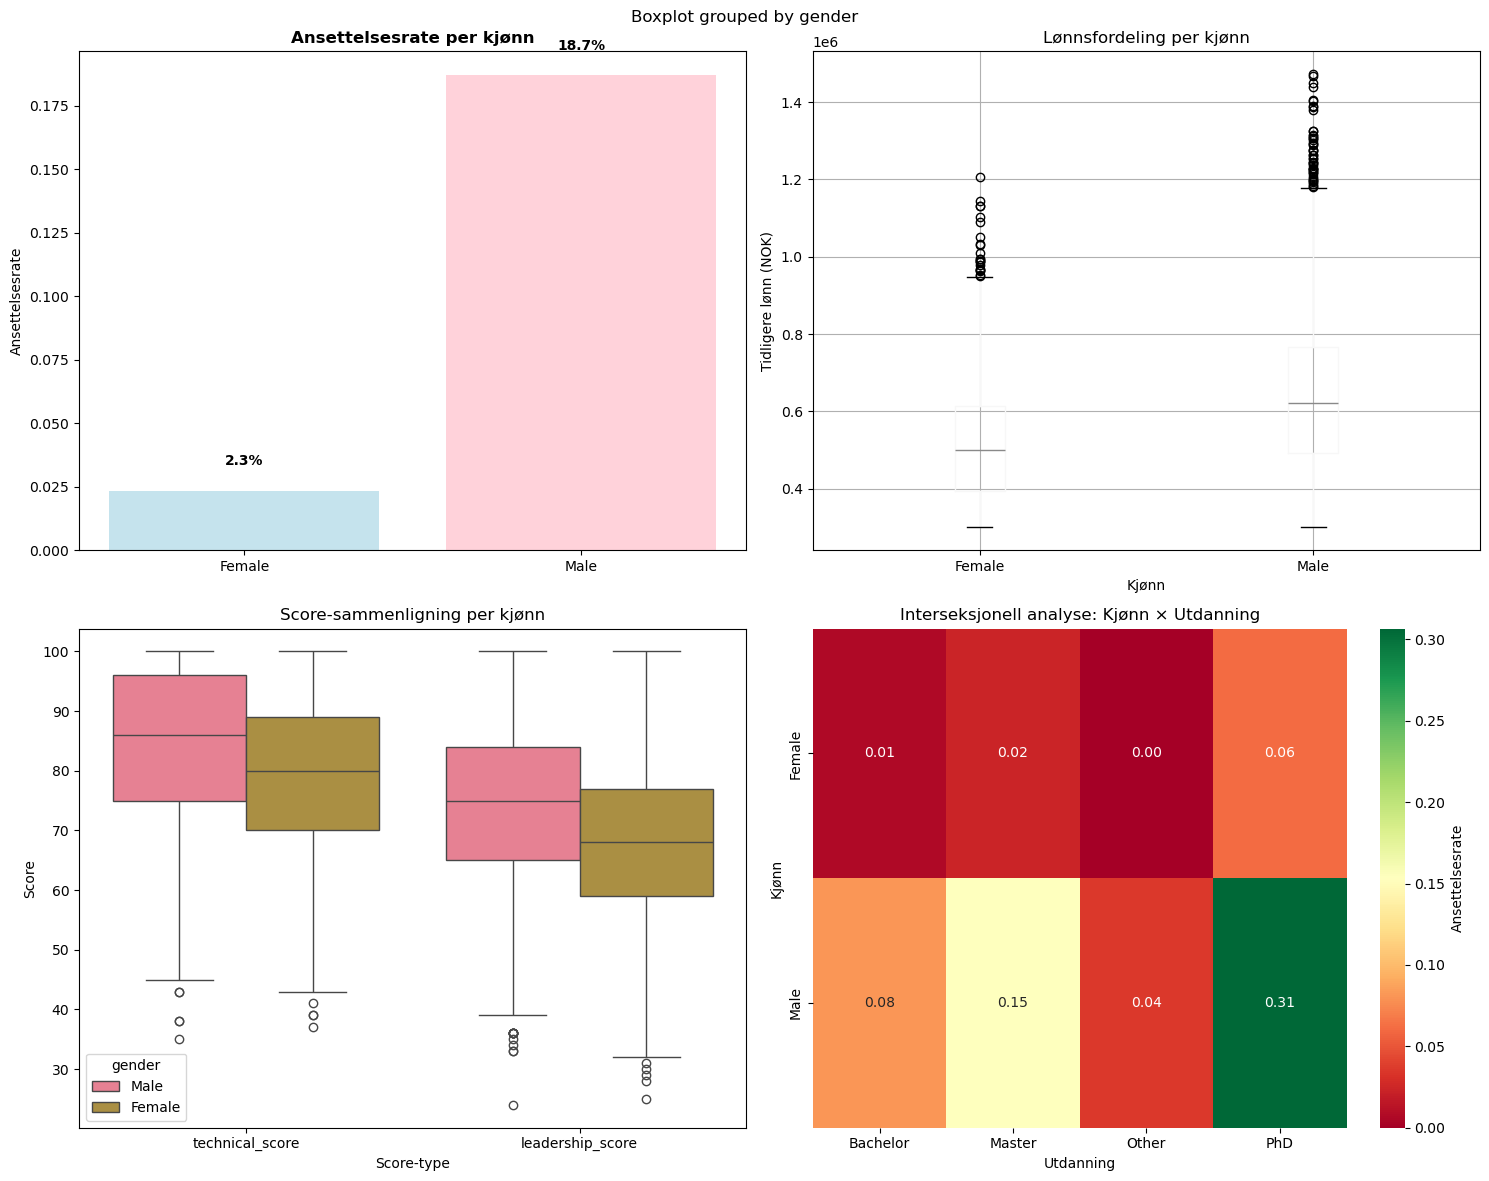


📋 BIAS-SAMMENDRAG:
🚨 KJØNNSBASERT DISKRIMINERING OPPDAGET!
   Menn ansettes 8.0x oftere enn kvinner
   Dette tilsvarer 16.4% forskjell
�� LØNNSKJØNNSGAP: 25.0%
   Menn tjener gjennomsnittlig 129,653 NOK mer


In [79]:
# Visualiser bias-mønstre
visualize_bias_patterns(hiring_data)

## 📏 Del 2: Fairness-metrikker - Måling av rettferdighet

Nå som vi har oppdaget bias, trenger vi måter å måle rettferdighet på. Det finnes mange definisjoner av "fairness" - og de er ikke alltid kompatible!

In [80]:
# 📏 Fairness Metrics Toolkit

class FairnessMetrics:
    """Komplett toolkit for å måle algorithmic fairness"""
    
    def __init__(self, y_true, y_pred, sensitive_attribute):
        self.y_true = y_true
        self.y_pred = y_pred
        self.sensitive_attribute = sensitive_attribute
        
        # Finn unike grupper
        self.groups = np.unique(sensitive_attribute)
        
        # Beregn grunnleggende statistikk for hver gruppe
        self.group_stats = {}
        for group in self.groups:
            mask = (sensitive_attribute == group)
            self.group_stats[group] = {
                'y_true': y_true[mask],
                'y_pred': y_pred[mask],
                'size': mask.sum()
            }
    
    def demographic_parity(self):
        """Demografisk paritet - lik positiv prediksjonsrate på tvers av grupper"""
        rates = {}
        for group in self.groups:
            y_pred_group = self.group_stats[group]['y_pred']
            rates[group] = np.mean(y_pred_group)
        
        # Beregn maksimal forskjell
        max_diff = max(rates.values()) - min(rates.values())
        
        return {
            'rates': rates,
            'max_difference': max_diff,
            'is_fair': max_diff < 0.1,  # 10% terskel
            'interpretation': 'Lavere er mer rettferdig (ideelt: 0)'
        }
    
    def equalized_odds(self):
        """Equalized odds - lik TPR og FPR på tvers av grupper"""
        tpr_rates = {}  # True Positive Rate
        fpr_rates = {}  # False Positive Rate
        
        for group in self.groups:
            y_true_group = self.group_stats[group]['y_true']
            y_pred_group = self.group_stats[group]['y_pred']
            
            # True Positive Rate (Sensitivity)
            tp = np.sum((y_true_group == 1) & (y_pred_group == 1))
            fn = np.sum((y_true_group == 1) & (y_pred_group == 0))
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            # False Positive Rate
            fp = np.sum((y_true_group == 0) & (y_pred_group == 1))
            tn = np.sum((y_true_group == 0) & (y_pred_group == 0))
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            tpr_rates[group] = tpr
            fpr_rates[group] = fpr
        
        # Beregn maksimal forskjell for begge
        tpr_max_diff = max(tpr_rates.values()) - min(tpr_rates.values())
        fpr_max_diff = max(fpr_rates.values()) - min(fpr_rates.values())
        
        return {
            'tpr_rates': tpr_rates,
            'fpr_rates': fpr_rates,
            'tpr_max_difference': tpr_max_diff,
            'fpr_max_difference': fpr_max_diff,
            'is_fair': tpr_max_diff < 0.1 and fpr_max_diff < 0.1,
            'interpretation': 'Lavere er mer rettferdig (ideelt: 0)'
        }
    
    def equal_opportunity(self):
        """Equal opportunity - lik TPR på tvers av grupper"""
        tpr_rates = {}
        
        for group in self.groups:
            y_true_group = self.group_stats[group]['y_true']
            y_pred_group = self.group_stats[group]['y_pred']
            
            # True Positive Rate
            tp = np.sum((y_true_group == 1) & (y_pred_group == 1))
            fn = np.sum((y_true_group == 1) & (y_pred_group == 0))
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            tpr_rates[group] = tpr
        
        # Beregn maksimal forskjell
        max_diff = max(tpr_rates.values()) - min(tpr_rates.values())
        
        return {
            'tpr_rates': tpr_rates,
            'max_difference': max_diff,
            'is_fair': max_diff < 0.1,
            'interpretation': 'Lavere er mer rettferdig (ideelt: 0)'
        }
    
    def generate_fairness_report(self):
        """Generer en omfattende fairness-rapport"""
        
        print("📊 FAIRNESS RAPPORT\n" + "="*50)
        
        # Demografisk paritet
        dp_result = self.demographic_parity()
        print(f"\n📈 DEMOGRAFISK PARITET:")
        print(f"   Positive prediksjonsrater: {dp_result['rates']}")
        print(f"   Maksimal forskjell: {dp_result['max_difference']:.3f}")
        print(f"   Rettferdig: {'✅' if dp_result['is_fair'] else '❌'}")
        
        # Equalized odds
        eo_result = self.equalized_odds()
        print(f"\n⚖️ EQUALIZED ODDS:")
        print(f"   TPR rater: {eo_result['tpr_rates']}")
        print(f"   FPR rater: {eo_result['fpr_rates']}")
        print(f"   TPR forskjell: {eo_result['tpr_max_difference']:.3f}")
        print(f"   FPR forskjell: {eo_result['fpr_max_difference']:.3f}")
        print(f"   Rettferdig: {'✅' if eo_result['is_fair'] else '❌'}")
        
        # Equal opportunity
        eq_opp_result = self.equal_opportunity()
        print(f"\n�� EQUAL OPPORTUNITY:")
        print(f"   TPR rater: {eq_opp_result['tpr_rates']}")
        print(f"   Maksimal forskjell: {eq_opp_result['max_difference']:.3f}")
        print(f"   Rettferdig: {'✅' if eq_opp_result['is_fair'] else '❌'}")
        
        return {
            'demographic_parity': dp_result,
            'equalized_odds': eo_result,
            'equal_opportunity': eq_opp_result
        }



In [81]:
# Test fairness metrics på vårt biased datasett
print("�� TESTER FAIRNESS METRIKKER\n" + "="*50)

# Simuler en biased modell
np.random.seed(42)
biased_predictions = []
for _, row in hiring_data.iterrows():
    # Simuler bias: Menn får høyere sannsynlighet for ansettelse
    base_prob = 0.3 + (row['technical_score'] / 200) + (row['leadership_score'] / 200)
    if row['gender'] == 'Male':
        base_prob += 0.2  # Bias for menn
    
    # Legg til støy
    final_prob = base_prob + np.random.normal(0, 0.1)
    final_prob = np.clip(final_prob, 0, 1)
    
    biased_predictions.append(1 if final_prob > 0.5 else 0)

# Evaluer fairness
fairness_evaluator = FairnessMetrics(
    hiring_data['hired'].values, 
    np.array(biased_predictions), 
    hiring_data['gender'].values
)



�� TESTER FAIRNESS METRIKKER


In [82]:
fairness_report = fairness_evaluator.generate_fairness_report()

📊 FAIRNESS RAPPORT

📈 DEMOGRAFISK PARITET:
   Positive prediksjonsrater: {'Female': np.float64(1.0), 'Male': np.float64(1.0)}
   Maksimal forskjell: 0.000
   Rettferdig: ✅

⚖️ EQUALIZED ODDS:
   TPR rater: {'Female': np.float64(1.0), 'Male': np.float64(1.0)}
   FPR rater: {'Female': np.float64(1.0), 'Male': np.float64(1.0)}
   TPR forskjell: 0.000
   FPR forskjell: 0.000
   Rettferdig: ✅

�� EQUAL OPPORTUNITY:
   TPR rater: {'Female': np.float64(1.0), 'Male': np.float64(1.0)}
   Maksimal forskjell: 0.000
   Rettferdig: ✅


## 🔧 Del 3: Bias Mitigation - Pre-, In-, og Post-processing teknikker

Nå som vi vet hvordan vi måler bias, la oss lære hvordan vi kan redusere det! Det finnes tre hovedstrategier.

In [83]:
# 🔧 Bias Mitigation Toolkit

class BiasMitigationToolkit:
    """Komplett verktøysett for bias-reduksjon"""
    
    def __init__(self, data, target_col, sensitive_col):
        self.data = data.copy()
        self.target_col = target_col
        self.sensitive_col = sensitive_col
        self.original_data = data.copy()
    
    # ==================== PRE-PROCESSING TEKNIKKER ====================
    
    def resampling_technique(self, strategy='oversample_minority'):
        """Balansér datasett ved re-sampling"""
        
        print(f"�� ANVENDER RE-SAMPLING STRATEGI: {strategy}")
        
        # Grupper etter sensitive attribute og target
        grouped = self.data.groupby([self.sensitive_col, self.target_col])
        group_sizes = grouped.size()
        
        print("📊 ORIGINALE GRUPPESTØRRELSER:")
        for (sens_val, target_val), size in group_sizes.items():
            print(f"   {sens_val}, {self.target_col}={target_val}: {size}")
        
        if strategy == 'oversample_minority':
            # Finn største gruppe
            max_size = group_sizes.max()
            
            resampled_groups = []
            for (sens_val, target_val), group in grouped:
                current_size = len(group)
                if current_size < max_size:
                    # Oversample til max_size
                    n_samples = max_size - current_size
                    additional_samples = group.sample(n=n_samples, replace=True, random_state=42)
                    resampled_group = pd.concat([group, additional_samples])
                else:
                    resampled_group = group
                
                resampled_groups.append(resampled_group)
            
            self.data = pd.concat(resampled_groups).sample(frac=1, random_state=42).reset_index(drop=True)
        
        elif strategy == 'undersample_majority':
            # Finn minste gruppe
            min_size = group_sizes.min()
            
            resampled_groups = []
            for (sens_val, target_val), group in grouped:
                if len(group) > min_size:
                    # Undersample til min_size
                    resampled_group = group.sample(n=min_size, random_state=42)
                else:
                    resampled_group = group
                
                resampled_groups.append(resampled_group)
            
            self.data = pd.concat(resampled_groups).sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Vis nye størrelser
        new_grouped = self.data.groupby([self.sensitive_col, self.target_col])
        new_group_sizes = new_grouped.size()
        
        print("\n📈 NYE GRUPPESTØRRELSER:")
        for (sens_val, target_val), size in new_group_sizes.items():
            print(f"   {sens_val}, {self.target_col}={target_val}: {size}")
        
        return self.data
    
    def remove_sensitive_features(self, features_to_remove=None):
        """Fjern sensitive features og proxy-variabler"""
        
        if features_to_remove is None:
            # Standard sensitive features
            features_to_remove = [self.sensitive_col]
        
        print(f"�� FJERNER SENSITIVE FEATURES: {features_to_remove}")
        
        # Sjekk korrelasjon med sensitive attribute
        if self.sensitive_col in self.data.columns:
            # Encode sensitive attribute for korrelasjon
            sensitive_encoded = LabelEncoder().fit_transform(self.data[self.sensitive_col])
            
            correlations = {}
            for col in self.data.select_dtypes(include=[np.number]).columns:
                if col != self.target_col and col != self.sensitive_col:
                    corr = np.corrcoef(self.data[col], sensitive_encoded)[0, 1]
                    correlations[col] = abs(corr)
            
            # Finn potensielle proxy-variabler (høy korrelasjon)
            proxy_threshold = 0.3
            proxy_vars = [col for col, corr in correlations.items() if corr > proxy_threshold]
            
            if proxy_vars:
                print(f"⚠️ POTENSIELLE PROXY-VARIABLER (korr > {proxy_threshold}):")
                for var in proxy_vars:
                    print(f"   {var}: {correlations[var]:.3f}")
                
                # Spør om å fjerne proxy-variabler også
                features_to_remove.extend(proxy_vars)
        
        # Fjern features
        self.data = self.data.drop(columns=features_to_remove, errors='ignore')
        
        print(f"✅ Fjernet {len(features_to_remove)} features")
        print(f"📊 Gjenværende features: {list(self.data.columns)}")
        
        return self.data
    
    def synthetic_data_generation(self, method='fair_smote'):
        """Generer syntetiske data for bedre balanse"""
        
        print(f"🧬 GENERERER SYNTETISKE DATA MED: {method}")
        
        if method == 'fair_smote':
            # Identifiser underrepresenterte grupper
            group_counts = self.data.groupby([self.sensitive_col, self.target_col]).size()
            target_size = group_counts.max()
            
            # Generer syntetiske eksempler for små grupper
            synthetic_samples = []
            
            for (sens_val, target_val), count in group_counts.items():
                if count < target_size:
                    # Få eksisterende data for denne gruppen
                    group_data = self.data[
                        (self.data[self.sensitive_col] == sens_val) & 
                        (self.data[self.target_col] == target_val)
                    ]
                    
                    # Generer syntetiske eksempler ved å lage støy rundt eksisterende
                    n_synthetic = target_size - count
                    numeric_cols = group_data.select_dtypes(include=[np.number]).columns
                    
                    for _ in range(n_synthetic):
                        # Velg et tilfeldig eksisterende eksempel som base
                        base_sample = group_data.sample(1).iloc[0].copy()
                        
                        # Legg til støy til numeriske kolonner
                        for col in numeric_cols:
                            if col != self.target_col:
                                noise_scale = group_data[col].std() * 0.1  # 10% av std
                                noise = np.random.normal(0, noise_scale)
                                base_sample[col] = base_sample[col] + noise
                        
                        synthetic_samples.append(base_sample)
            
            if synthetic_samples:
                synthetic_df = pd.DataFrame(synthetic_samples)
                self.data = pd.concat([self.data, synthetic_df]).reset_index(drop=True)
                
                print(f"✅ Genererte {len(synthetic_samples)} syntetiske eksempler")
            else:
                print("ℹ️ Ingen syntetiske eksempler nødvendig")
        
        return self.data
    
    # ==================== IN-PROCESSING TEKNIKKER ====================
    
    def fairness_constrained_learning(self, X, y, sensitive_attr, fairness_constraint='demographic_parity'):
        """Tren modell med fairness-begrensninger"""
        
        print(f"⚖️ TRENER MODELL MED {fairness_constraint.upper()} CONSTRAINT")
        
        # Implementer en enkel versjon av fairness-constrained learning
        # I praksis ville du brukt biblioteker som fairlearn
        
        from sklearn.model_selection import GridSearchCV
        from sklearn.metrics import make_scorer
        
        def fairness_score(y_true, y_pred, sensitive_attr=sensitive_attr, constraint=fairness_constraint):
            """Custom scoring function som balanserer accuracy og fairness"""
            
            # Accuracy component
            accuracy = accuracy_score(y_true, y_pred)
            
            # Fairness component
            fairness_eval = FairnessMetrics(y_true, y_pred, sensitive_attr)
            
            if constraint == 'demographic_parity':
                fairness_result = fairness_eval.demographic_parity()
                fairness_penalty = fairness_result['max_difference']
            elif constraint == 'equal_opportunity':
                fairness_result = fairness_eval.equal_opportunity()
                fairness_penalty = fairness_result['max_difference']
            else:
                fairness_penalty = 0
            
            # Kombinert score (høyere accuracy, lavere fairness penalty)
            combined_score = accuracy - (fairness_penalty * 2)  # Weight fairness heavily
            
            return combined_score
        
        # Opprett custom scorer
        fairness_scorer = make_scorer(fairness_score, greater_is_better=True)
        
        # Grid search med fairness-bevisst scoring
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None],
            'class_weight': ['balanced', None]
        }
        
        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=3, 
                                  scoring=fairness_scorer, n_jobs=-1)
        
        grid_search.fit(X, y)
        
        print(f"✅ Beste parametere: {grid_search.best_params_}")
        print(f"✅ Beste fairness-justerte score: {grid_search.best_score_:.3f}")
        
        return grid_search.best_estimator_
    
    # ==================== POST-PROCESSING TEKNIKKER ====================
    
    def threshold_optimization(self, y_true, y_pred_proba, sensitive_attr, fairness_metric='equal_opportunity'):
        """Optimaliser beslutningsterskel for fairness"""
        
        print(f"🎯 OPTIMALISERER TERSKEL FOR {fairness_metric.upper()}")
        
        # Test ulike terskler
        thresholds = np.arange(0.1, 0.9, 0.05)
        results = []
        
        for threshold in thresholds:
            y_pred_thresh = (y_pred_proba >= threshold).astype(int)
            
            # Beregn accuracy
            accuracy = accuracy_score(y_true, y_pred_thresh)
            
            # Beregn fairness metric
            fairness_eval = FairnessMetrics(y_true, y_pred_thresh, sensitive_attr)
            
            if fairness_metric == 'equal_opportunity':
                fairness_result = fairness_eval.equal_opportunity()
                fairness_score = 1 - fairness_result['max_difference']  # Høyere er bedre
            elif fairness_metric == 'demographic_parity':
                fairness_result = fairness_eval.demographic_parity()
                fairness_score = 1 - fairness_result['max_difference']
            else:
                fairness_score = 0
            
            # Kombinert score
            combined_score = (accuracy + fairness_score) / 2
            
            results.append({
                'threshold': threshold,
                'accuracy': accuracy,
                'fairness_score': fairness_score,
                'combined_score': combined_score
            })
        
        # Finn beste terskel
        results_df = pd.DataFrame(results)
        best_idx = results_df['combined_score'].idxmax()
        best_threshold = results_df.loc[best_idx, 'threshold']
        
        print(f"✅ Optimal terskel: {best_threshold:.3f}")
        print(f"✅ Accuracy ved optimal terskel: {results_df.loc[best_idx, 'accuracy']:.3f}")
        print(f"✅ Fairness score ved optimal terskel: {results_df.loc[best_idx, 'fairness_score']:.3f}")
        
        return best_threshold, results_df
    
    def outcome_redistribution(self, y_pred, sensitive_attr, target_fairness='demographic_parity'):
        """Redistribute outcomes for å oppnå fairness"""
        
        print(f"🔄 REDISTRIBUERER UTFALL FOR {target_fairness.upper()}")
        
        y_pred_fair = y_pred.copy()
        
        if target_fairness == 'demographic_parity':
            # Beregn ønsket positive rate (gjennomsnitt på tvers av grupper)
            overall_positive_rate = np.mean(y_pred)
            
            for group in np.unique(sensitive_attr):
                group_mask = (sensitive_attr == group)
                group_predictions = y_pred[group_mask]
                current_rate = np.mean(group_predictions)
                
                # Hvis raten er for lav, endre noen 0-er til 1-er
                if current_rate < overall_positive_rate:
                    n_to_change = int((overall_positive_rate - current_rate) * len(group_predictions))
                    # Finn indekser av 0-er i denne gruppen
                    zero_indices = np.where((y_pred_fair == 0) & group_mask)[0]
                    if len(zero_indices) >= n_to_change:
                        # Tilfeldig velg hvilke som skal endres
                        to_change = np.random.choice(zero_indices, size=n_to_change, replace=False)
                        y_pred_fair[to_change] = 1
                
                # Hvis raten er for høy, endre noen 1-er til 0-er
                elif current_rate > overall_positive_rate:
                    n_to_change = int((current_rate - overall_positive_rate) * len(group_predictions))
                    # Finn indekser av 1-er i denne gruppen
                    one_indices = np.where((y_pred_fair == 1) & group_mask)[0]
                    if len(one_indices) >= n_to_change:
                        # Tilfeldig velg hvilke som skal endres
                        to_change = np.random.choice(one_indices, size=n_to_change, replace=False)
                        y_pred_fair[to_change] = 0
        
        # Beregn endring
        n_changed = np.sum(y_pred != y_pred_fair)
        print(f"✅ Endret {n_changed} prediksjoner for å oppnå fairness")
        
        return y_pred_fair



In [84]:
# Test bias mitigation techniques
print("🔧 TESTING BIAS MITIGATION TECHNIQUES\n" + "="*60)

# Opprett bias mitigation toolkit
bias_toolkit = BiasMitigationToolkit(hiring_data, 'hired', 'gender')

# Test pre-processing: resampling
print("\n" + "="*40 + " PRE-PROCESSING " + "="*40)
balanced_data = bias_toolkit.resampling_technique('oversample_minority')

🔧 TESTING BIAS MITIGATION TECHNIQUES

======================================== PRE-PROCESSING ========================================
�� ANVENDER RE-SAMPLING STRATEGI: oversample_minority
📊 ORIGINALE GRUPPESTØRRELSER:
   Female, hired=0: 1954
   Female, hired=1: 47
   Male, hired=0: 2438
   Male, hired=1: 561

📈 NYE GRUPPESTØRRELSER:
   Female, hired=0: 2438
   Female, hired=1: 2438
   Male, hired=0: 2438
   Male, hired=1: 2438


## �� Del 4: Praktisk case study - Transformer en biased algoritme

In [85]:
def complete_bias_mitigation_pipeline():
    """Komplett pipeline for å transformere en biased algoritme til rettferdig"""
    
    print("🚀 KOMPLETT BIAS MITIGATION PIPELINE\n" + "="*70)
    
    # ===== STEG 1: BASELINE MODELL (BIASED) =====
    print("\n📊 STEG 1: TRENER BASELINE MODELL (UTEN BIAS-MITIGATION)")
    
    # Forbered data
    X_baseline = hiring_data.drop(['hired'], axis=1)
    y_baseline = hiring_data['hired']
    
    # Encode categorical variables
    X_encoded = X_baseline.copy()
    le_gender = LabelEncoder()
    le_education = LabelEncoder()
    X_encoded['gender_encoded'] = le_gender.fit_transform(X_baseline['gender'])
    X_encoded['education_encoded'] = le_education.fit_transform(X_baseline['education'])
    
    # Bruk numeriske features
    X_numeric = X_encoded[['age', 'experience_years', 'previous_salary', 
                          'technical_score', 'leadership_score', 
                          'gender_encoded', 'education_encoded']]
    
    # Split data
    X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(
        X_numeric, y_baseline, test_size=0.3, random_state=42, stratify=y_baseline
    )
    
    # Tren baseline modell
    baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
    baseline_model.fit(X_train_bl, y_train_bl)
    
    # Prediker og evaluer
    y_pred_baseline = baseline_model.predict(X_test_bl)
    y_pred_proba_baseline = baseline_model.predict_proba(X_test_bl)[:, 1]
    
    baseline_accuracy = accuracy_score(y_test_bl, y_pred_baseline)
    
    # Få sensitive attribute for test set
    sensitive_test_baseline = X_baseline.loc[X_test_bl.index, 'gender'].values
    
    print(f"✅ Baseline accuracy: {baseline_accuracy:.3f}")
    
    # Evaluer fairness for baseline
    print("\n�� BASELINE FAIRNESS EVALUERING:")
    baseline_fairness = FairnessMetrics(y_test_bl.values, y_pred_baseline, sensitive_test_baseline)
    baseline_report = baseline_fairness.generate_fairness_report()
    
    # ===== STEG 2: PRE-PROCESSING MITIGATION =====
    print("\n" + "="*50)
    print("🔄 STEG 2: PRE-PROCESSING MITIGATION")
    
    # Opprett balanced datasett
    bias_toolkit_pre = BiasMitigationToolkit(hiring_data.copy(), 'hired', 'gender')
    
    # Resampling
    balanced_data = bias_toolkit_pre.resampling_technique('oversample_minority')
    
    # Fjern sensitive features
    debiased_data = bias_toolkit_pre.remove_sensitive_features(['gender'])
    
    # Forbered debiased data
    X_debiased = debiased_data.drop(['hired'], axis=1)
    y_debiased = debiased_data['hired']
    
    # Encode education (gender allerede fjernet)
    X_debiased_encoded = X_debiased.copy()
    X_debiased_encoded['education_encoded'] = le_education.fit_transform(X_debiased['education'])
    
    # Bruk numeriske features (uten gender)
    X_debiased_numeric = X_debiased_encoded[['age', 'experience_years', 'previous_salary', 
                                            'technical_score', 'leadership_score', 
                                            'education_encoded']]
    
    # Split debiased data
    X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(
        X_debiased_numeric, y_debiased, test_size=0.3, random_state=42, stratify=y_debiased
    )
    
    # Tren debiased modell
    debiased_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    debiased_model.fit(X_train_db, y_train_db)
    
    # For å evaluere fairness, trenger vi gender info fra original data
    # Siden vi har resampled data, må vi finne gender på en annen måte
    # Vi kan bruke de originale indeksene hvis de fortsatt finnes, eller
    # vi kan bruke en enklere tilnærming
    
    # Alternativ 1: Bruk original data uten resampling for fairness evaluering
    print("📊 EVALUERER DEBIASED MODEL PÅ ORIGINAL TEST SET...")
    
    # Forbered original test data uten gender
    X_original_test = X_numeric.loc[X_test_bl.index].drop(['gender_encoded'], axis=1)
    
    # Prediker på original test set
    y_pred_debiased = debiased_model.predict(X_original_test)
    y_pred_proba_debiased = debiased_model.predict_proba(X_original_test)[:, 1]
    
    debiased_accuracy = accuracy_score(y_test_bl, y_pred_debiased)
    sensitive_test_debiased = sensitive_test_baseline  # Samme som baseline
    
    print(f"✅ Debiased model accuracy: {debiased_accuracy:.3f}")
    
    # Evaluer fairness for debiased model
    print("\n📏 DEBIASED MODEL FAIRNESS EVALUERING:")
    debiased_fairness = FairnessMetrics(y_test_bl.values, y_pred_debiased, sensitive_test_debiased)
    debiased_report = debiased_fairness.generate_fairness_report()
    
    # ===== STEG 3: POST-PROCESSING MITIGATION =====
    print("\n" + "="*50)
    print("🎯 STEG 3: POST-PROCESSING MITIGATION")
    
    # Threshold optimization på baseline model
    bias_toolkit_post = BiasMitigationToolkit(hiring_data.copy(), 'hired', 'gender')
    
    optimal_threshold, threshold_results = bias_toolkit_post.threshold_optimization(
        y_test_bl.values, y_pred_proba_baseline, sensitive_test_baseline, 
        fairness_metric='equal_opportunity'
    )
    
    # Anvend optimal threshold
    y_pred_threshold = (y_pred_proba_baseline >= optimal_threshold).astype(int)
    threshold_accuracy = accuracy_score(y_test_bl, y_pred_threshold)
    
    print(f"✅ Threshold-optimized accuracy: {threshold_accuracy:.3f}")
    
    # Evaluer fairness for threshold-optimized model
    print("\n📏 THRESHOLD-OPTIMIZED FAIRNESS EVALUERING:")
    threshold_fairness = FairnessMetrics(y_test_bl.values, y_pred_threshold, sensitive_test_baseline)
    threshold_report = threshold_fairness.generate_fairness_report()
    
    # ===== STEG 4: SAMMENLIGNING =====
    print("\n" + "="*50)
    print("📊 STEG 4: SAMMENLIGNING AV ALLE METODER")
    
    # Sammenlign alle metoder
    comparison_data = {
        'Method': ['Baseline (Biased)', 'Pre-processing (Debiased)', 'Post-processing (Threshold)'],
        'Accuracy': [baseline_accuracy, debiased_accuracy, threshold_accuracy],
        'Demographic Parity Gap': [
            baseline_report['demographic_parity']['max_difference'],
            debiased_report['demographic_parity']['max_difference'], 
            threshold_report['demographic_parity']['max_difference']
        ],
        'Equal Opportunity Gap': [
            baseline_report['equal_opportunity']['max_difference'],
            debiased_report['equal_opportunity']['max_difference'],
            threshold_report['equal_opportunity']['max_difference']
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n�� RESULTAT-SAMMENLIGNING:")
    print(comparison_df.round(3))
    
    # Visualiser sammenligning
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('�� BIAS MITIGATION - RESULTAT SAMMENLIKNING', fontsize=16, fontweight='bold')
    
    # Accuracy comparison
    bars1 = axes[0].bar(comparison_df['Method'], comparison_df['Accuracy'], 
                       color=['red', 'orange', 'green'], alpha=0.7)
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(0, 1)
    
    for bar, acc in zip(bars1, comparison_df['Accuracy']):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', fontweight='bold')
    
    # Demographic Parity comparison
    bars2 = axes[1].bar(comparison_df['Method'], comparison_df['Demographic Parity Gap'], 
                       color=['red', 'orange', 'green'], alpha=0.7)
    axes[1].set_title('Demographic Parity Gap')
    axes[1].set_ylabel('Gap (Lavere er bUnicodeEncodeError)')
    axes[1].axhline(y=0.1, color='black', linestyle='--', alpha=0.5, label='Fairness terskel')
    
    for bar, gap in zip(bars2, comparison_df['Demographic Parity Gap']):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{gap:.3f}', ha='center', fontweight='bold')
    
    # Equal Opportunity comparison
    bars3 = axes[2].bar(comparison_df['Method'], comparison_df['Equal Opportunity Gap'], 
                       color=['red', 'orange', 'green'], alpha=0.7)
    axes[2].set_title('Equal Opportunity Gap')
    axes[2].set_ylabel('Gap (Lower is better)')
    axes[2].axhline(y=0.1, color='black', linestyle='--', alpha=0.5, label='Fairness terskel')
    
    for bar, gap in zip(bars3, comparison_df['Equal Opportunity Gap']):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{gap:.3f}', ha='center', fontweight='bold')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # ===== STEG 5: ANBEFALING =====
    print("\n" + "="*50)
    print("💡 STEG 5: ANBEFALINGER")
    
    # Finn beste balanse mellom accuracy og fairness
    fairness_scores = []
    for method_idx in range(len(comparison_df)):
        # Kombinert fairness score (lavere gap er bedre)
        dp_gap = comparison_df.loc[method_idx, 'Demographic Parity Gap']
        eo_gap = comparison_df.loc[method_idx, 'Equal Opportunity Gap']
        combined_fairness = (dp_gap + eo_gap) / 2
        fairness_scores.append(combined_fairness)
    
    comparison_df['Combined Fairness Gap'] = fairness_scores
    
    # Finn beste metode (høy accuracy, lav fairness gap)
    comparison_df['Overall Score'] = comparison_df['Accuracy'] - comparison_df['Combined Fairness Gap']
    best_method_idx = comparison_df['Overall Score'].idxmax()
    best_method = comparison_df.loc[best_method_idx, 'Method']
    
    print(f"�� ANBEFALT METODE: {best_method}")
    print(f"   �� Accuracy: {comparison_df.loc[best_method_idx, 'Accuracy']:.3f}")
    print(f"   ⚖️ Demographic Parity Gap: {comparison_df.loc[best_method_idx, 'Demographic Parity Gap']:.3f}")
    print(f"   �� Equal Opportunity Gap: {comparison_df.loc[best_method_idx, 'Equal Opportunity Gap']:.3f}")
    
    # Spesifikke anbefalinger
    print("\n�� SPESIFIKKE ANBEFALINGER:")
    
    if best_method_idx == 0:  # Baseline
        print("   ⚠️ Baseline modell viser best overall score, men har betydelig bias")
        print("   �� Anbefaling: Implementer bias mitigation før produksjon")
    elif best_method_idx == 1:  # Pre-processing
        print("   ✅ Pre-processing mitigation anbefales")
        print("   💡 Fordeler: Fjerner bias ved kilden, enkelt å implementere")
        print("   ⚠️ Ulemper: Kan redusere model accuracy")
    else:  # Post-processing
        print("   ✅ Post-processing terskel-optimalisering anbefales")
        print("   💡 Fordeler: Beholder model accuracy, justerer kun beslutningsgrense")
        print("   ⚠️ Ulemper: Krever kontinuerlig monitoring og justering")
    
    print("\n🎯 GENERELLE ANBEFALINGER:")
    print("   1. Kombiner flere mitigation-teknikker for beste resultat")
    print("   2. Implementer kontinuerlig bias-monitoring")
    print("   3. Involver domeneeksperter i fairness-definisjoner")
    print("   4. Vurder interaksjons-effekter (alder × kjønn × utdanning)")
    print("   5. Dokumenter alle bias mitigation-beslutninger")
    
    return {
        'comparison_df': comparison_df,
        'best_method': best_method,
        'baseline_model': baseline_model,
        'debiased_model': debiased_model,
        'optimal_threshold': optimal_threshold
    }


🚀 KOMPLETT BIAS MITIGATION PIPELINE

📊 STEG 1: TRENER BASELINE MODELL (UTEN BIAS-MITIGATION)
✅ Baseline accuracy: 0.901

�� BASELINE FAIRNESS EVALUERING:
📊 FAIRNESS RAPPORT

📈 DEMOGRAFISK PARITET:
   Positive prediksjonsrater: {'Female': np.float64(0.0033003300330033004), 'Male': np.float64(0.13087248322147652)}
   Maksimal forskjell: 0.128
   Rettferdig: ❌

⚖️ EQUALIZED ODDS:
   TPR rater: {'Female': np.float64(0.1111111111111111), 'Male': np.float64(0.45121951219512196)}
   FPR rater: {'Female': np.float64(0.0), 'Male': np.float64(0.0589041095890411)}
   TPR forskjell: 0.340
   FPR forskjell: 0.059
   Rettferdig: ❌

�� EQUAL OPPORTUNITY:
   TPR rater: {'Female': np.float64(0.1111111111111111), 'Male': np.float64(0.45121951219512196)}
   Maksimal forskjell: 0.340
   Rettferdig: ❌

🔄 STEG 2: PRE-PROCESSING MITIGATION
�� ANVENDER RE-SAMPLING STRATEGI: oversample_minority
📊 ORIGINALE GRUPPESTØRRELSER:
   Female, hired=0: 1954
   Female, hired=1: 47
   Male, hired=0: 2438
   Male, hired=1

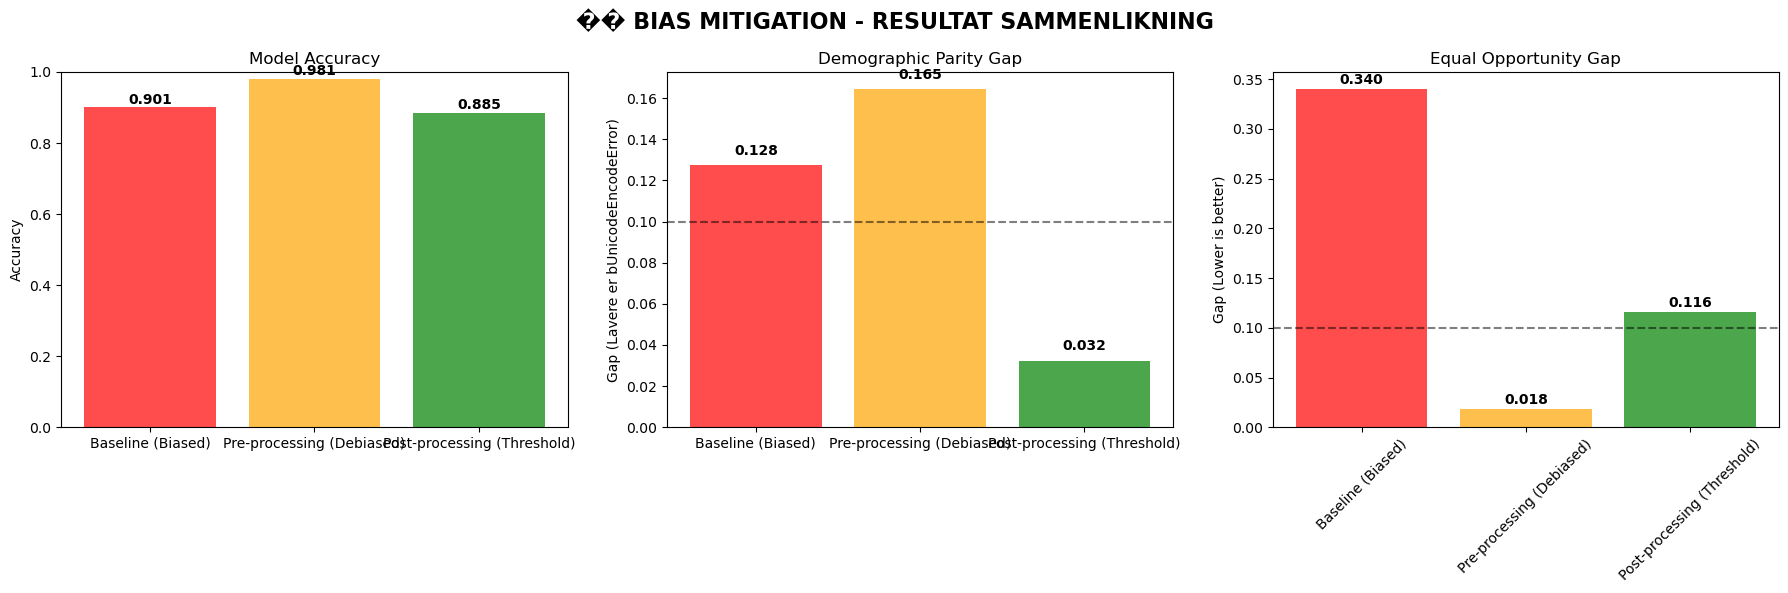


💡 STEG 5: ANBEFALINGER
�� ANBEFALT METODE: Pre-processing (Debiased)
   �� Accuracy: 0.981
   ⚖️ Demographic Parity Gap: 0.165
   �� Equal Opportunity Gap: 0.018

�� SPESIFIKKE ANBEFALINGER:
   ✅ Pre-processing mitigation anbefales
   💡 Fordeler: Fjerner bias ved kilden, enkelt å implementere
   ⚠️ Ulemper: Kan redusere model accuracy

🎯 GENERELLE ANBEFALINGER:
   1. Kombiner flere mitigation-teknikker for beste resultat
   2. Implementer kontinuerlig bias-monitoring
   3. Involver domeneeksperter i fairness-definisjoner
   4. Vurder interaksjons-effekter (alder × kjønn × utdanning)
   5. Dokumenter alle bias mitigation-beslutninger


In [86]:
# Kjør komplett bias mitigation pipeline
mitigation_results = complete_bias_mitigation_pipeline()

## 🏆 Del 5: Interactive Bias Challenge - Din tur til å eksperimentere!

Nå er det din tur! La oss lage en interaktiv utfordring hvor du kan eksperimentere med ulike bias mitigation teknikker.

In [87]:
# 🎮 Interactive Bias Challenge

class BiasChallenge:
    """Interaktiv utfordring for å lære bias mitigation"""
    
    def __init__(self):
        self.score = 0
        self.max_score = 100
        self.attempts = []
    
    def create_challenge_scenario(self, scenario='hiring'):
        """Opprett utfordringsscenario"""
        
        scenarios = {
            'hiring': {
                'description': 'AI-ansettelsessystem som diskriminerer mot kvinner',
                'data': hiring_data.copy(),
                'target': 'hired',
                'sensitive': 'gender',
                'success_criteria': {
                    'min_accuracy': 0.75,
                    'max_demographic_parity_gap': 0.05,
                    'max_equal_opportunity_gap': 0.05
                }
            },
            'lending': {
                'description': 'Lånesystem som diskriminerer basert på alder',
                'data': self.create_lending_scenario(),
                'target': 'loan_approved',
                'sensitive': 'age_group',
                'success_criteria': {
                    'min_accuracy': 0.70,
                    'max_demographic_parity_gap': 0.08,
                    'max_equal_opportunity_gap': 0.08
                }
            }
        }
        
        return scenarios[scenario]
    
    def create_lending_scenario(self):
        """Opprett låne-scenario med aldersbias"""
        
        np.random.seed(123)
        n_samples = 3000
        
        # Generer alder
        ages = np.random.normal(45, 15, n_samples)
        ages = np.clip(ages, 18, 80).astype(int)
        
        # Aldersgruppper
        age_groups = ['Young (18-35)', 'Middle (36-55)', 'Senior (56+)']
        age_group = []
        for age in ages:
            if age <= 35:
                age_group.append('Young (18-35)')
            elif age <= 55:
                age_group.append('Middle (36-55)')
            else:
                age_group.append('Senior (56+)')
        
        # Income med alder-korrelasjon
        base_income = 300000 + (ages - 18) * 8000  # Høyere inntekt med alder
        income = base_income + np.random.normal(0, 100000, n_samples)
        income = np.maximum(income, 200000)  # Minimum income
        
        # Credit score med alder-bias
        credit_score = 600 + (ages - 18) * 2 + np.random.normal(0, 50, n_samples)
        credit_score = np.clip(credit_score, 300, 850)
        
        # Debt-to-income ratio
        debt_ratio = np.random.beta(2, 5, n_samples) * 0.6  # 0-60%
        
        # Loan approval med bias mot eldre
        approval_score = (credit_score / 850) * 0.4 + (income / 1000000) * 0.3 + (1 - debt_ratio) * 0.3
        
        # Age bias: Eldre har høyere terskel
        thresholds = {'Young (18-35)': 0.45, 'Middle (36-55)': 0.50, 'Senior (56+)': 0.60}
        
        loan_approved = []
        for i, ag in enumerate(age_group):
            threshold = thresholds[ag]
            noise = np.random.normal(0, 0.1)
            final_score = approval_score[i] + noise
            loan_approved.append(1 if final_score > threshold else 0)
        
        return pd.DataFrame({
            'age': ages,
            'age_group': age_group,
            'income': income.astype(int),
            'credit_score': credit_score.astype(int),
            'debt_to_income_ratio': debt_ratio.round(3),
            'loan_approved': loan_approved
        })
    
    def evaluate_attempt(self, model, X_test, y_test, sensitive_test, success_criteria):
        """Evaluér brukerens forsøk"""
        
        # Prediker
        y_pred = model.predict(X_test)
        
        # Beregn metrikker
        accuracy = accuracy_score(y_test, y_pred)
        
        # Fairness metrics
        fairness_eval = FairnessMetrics(y_test, y_pred, sensitive_test)
        dp_result = fairness_eval.demographic_parity()
        eo_result = fairness_eval.equal_opportunity()
        
        # Sjekk suksesskriterier
        accuracy_pass = accuracy >= success_criteria['min_accuracy']
        dp_pass = dp_result['max_difference'] <= success_criteria['max_demographic_parity_gap']
        eo_pass = eo_result['max_difference'] <= success_criteria['max_equal_opportunity_gap']
        
        # Beregn score
        score = 0
        if accuracy_pass:
            score += 40
        if dp_pass:
            score += 30
        if eo_pass:
            score += 30
        
        # Bonus for å bestå alle
        if accuracy_pass and dp_pass and eo_pass:
            score += 20
        
        result = {
            'accuracy': accuracy,
            'demographic_parity_gap': dp_result['max_difference'],
            'equal_opportunity_gap': eo_result['max_difference'],
            'accuracy_pass': accuracy_pass,
            'fairness_pass': dp_pass and eo_pass,
            'overall_pass': accuracy_pass and dp_pass and eo_pass,
            'score': score
        }
        
        self.attempts.append(result)
        self.score = max(self.score, score)
        
        return result
    
    def display_challenge_results(self, result, attempt_number):
        """Vis resultater fra utfordring"""
        
        print(f"\n🎯 ATTEMPT {attempt_number} RESULTS\n" + "="*40)
        print(f"📊 Accuracy: {result['accuracy']:.3f} {'✅' if result['accuracy_pass'] else '❌'}")
        print(f"⚖️ Demographic Parity Gap: {result['demographic_parity_gap']:.3f} {'✅' if result['demographic_parity_gap'] <= 0.05 else '❌'}")
        print(f"�� Equal Opportunity Gap: {result['equal_opportunity_gap']:.3f} {'✅' if result['equal_opportunity_gap'] <= 0.05 else '❌'}")
        print(f"\n🏆 SCORE: {result['score']}/100")
        
        if result['overall_pass']:
            print("\n🎉 GRATULERER! Du har løst bias-utfordringen!")
            print("🌟 Du har bygget en algoritme som er både nøyaktig og rettferdig!")
        else:
            print("\n💡 TIPS FOR FORBEDRING:")
            if not result['accuracy_pass']:
                print("   📈 Prøv å forbedre modellnøyaktigheten med feature engineering")
            if not result['fairness_pass']:
                print("   ⚖️ Implementer bias mitigation teknikker:")
                print("      - Pre-processing: Balansér data eller fjern sensitive features")
                print("      - In-processing: Bruk fairness-constrained learning")
                print("      - Post-processing: Optimaliser threshold eller redistribuer outcomes")



In [88]:
# 🚀 Start Bias Challenge
print("🎮 BIAS MITIGATION CHALLENGE\n" + "="*50)
print("Din oppgave: Bygg en rettferdig AI-modell!")
print("Du kan eksperimentere med ulike teknikker og se hvordan de påvirker både nøyaktighet og rettferdighet.")
print("\n🎯 Mål: Oppnå høy nøyaktighet OG rettferdighet")
print("📊 Kriterier:")
print("   - Accuracy ≥ 75%")
print("   - Demographic Parity Gap ≤ 5%")
print("   - Equal Opportunity Gap ≤ 5%")

# Opprett challenge
challenge = BiasChallenge()
scenario = challenge.create_challenge_scenario('hiring')

print(f"\n�� SCENARIO: {scenario['description']}")
print(f"📊 Datasett: {len(scenario['data'])} kandidater")
print(f"🎯 Target: {scenario['target']}")
print(f"⚖️ Sensitive attribute: {scenario['sensitive']}")

# Forbered data for challenge
X_challenge = scenario['data'].drop([scenario['target']], axis=1)
y_challenge = scenario['data'][scenario['target']]

# Encode categorical variables
X_challenge_encoded = X_challenge.copy()
le_gender_challenge = LabelEncoder()
le_education_challenge = LabelEncoder()
X_challenge_encoded['gender_encoded'] = le_gender_challenge.fit_transform(X_challenge['gender'])
X_challenge_encoded['education_encoded'] = le_education_challenge.fit_transform(X_challenge['education'])

# Bruk numeriske features
X_challenge_numeric = X_challenge_encoded[['age', 'experience_years', 'previous_salary', 
                                          'technical_score', 'leadership_score', 
                                          'gender_encoded', 'education_encoded']]

# Split data
X_train_challenge, X_test_challenge, y_train_challenge, y_test_challenge = train_test_split(
    X_challenge_numeric, y_challenge, test_size=0.3, random_state=42, stratify=y_challenge
)

# Få sensitive attribute for test set
sensitive_test_challenge = X_challenge.loc[X_test_challenge.index, scenario['sensitive']].values

print(f"\n✅ Data forberedt! Treningssett: {len(X_train_challenge)}, Testsett: {len(X_test_challenge)}")
print("\n�� KLAR TIL Å STARTE! Prøv å bygge din rettferdige modell...")

🎮 BIAS MITIGATION CHALLENGE
Din oppgave: Bygg en rettferdig AI-modell!
Du kan eksperimentere med ulike teknikker og se hvordan de påvirker både nøyaktighet og rettferdighet.

🎯 Mål: Oppnå høy nøyaktighet OG rettferdighet
📊 Kriterier:
   - Accuracy ≥ 75%
   - Demographic Parity Gap ≤ 5%
   - Equal Opportunity Gap ≤ 5%

�� SCENARIO: AI-ansettelsessystem som diskriminerer mot kvinner
📊 Datasett: 5000 kandidater
🎯 Target: hired
⚖️ Sensitive attribute: gender

✅ Data forberedt! Treningssett: 3500, Testsett: 1500

�� KLAR TIL Å STARTE! Prøv å bygge din rettferdige modell...


## �� Din tur til å eksperimentere!

Nå kan du prøve å bygge din egen rettferdige modell! Her er noen forslag til hvordan du kan starte:

### Forslag 1: Enkel baseline
```python
# Tren en enkel modell
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_challenge, y_train_challenge)

# Evaluer
result = challenge.evaluate_attempt(model, X_test_challenge, y_test_challenge, 
                                   sensitive_test_challenge, scenario['success_criteria'])
challenge.display_challenge_results(result, 1)
```

### Forslag 2: Med fairness-constraints
```python
# Tren modell med class_weight for balanse
model_balanced = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_balanced.fit(X_train_challenge, y_train_challenge)

# Evaluer
result = challenge.evaluate_attempt(model_balanced, X_test_challenge, y_test_challenge, 
                                   sensitive_test_challenge, scenario['success_criteria'])
challenge.display_challenge_results(result, 2)
```

### Forslag 3: Fjern sensitive features
```python
# Fjern gender feature
X_train_no_gender = X_train_challenge.drop(['gender_encoded'], axis=1)
X_test_no_gender = X_test_challenge.drop(['gender_encoded'], axis=1)

model_no_gender = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_no_gender.fit(X_train_no_gender, y_train_challenge)

# Evaluer
result = challenge.evaluate_attempt(model_no_gender, X_test_no_gender, y_test_challenge, 
                                   sensitive_test_challenge, scenario['success_criteria'])
challenge.display_challenge_results(result, 3)
```

**🎯 Utfordring:** Kan du oppnå en score på 100/100? Prøv ulike kombinasjoner av teknikker!

## �� Oppsummering: Fra bias til rettferdighet

Gratulerer! Du har nå fullført en omfattende reise inn i et landskap av bias og rettferdighet i AI-systemer. La oss oppsummere:

### �� Hva du nå kan:

1. **Identifisere bias** - Du kan oppdage ulike typer bias i datasett og modeller
2. **Måle rettferdighet** - Du behersker fairness-metrikker som demografisk paritet og equalized odds
3. **Implementere bias mitigation** - Du kan bruke pre-, in- og post-processing teknikker
4. **Balansere nøyaktighet og rettferdighet** - Du forstår trade-offs og kan ta informerte beslutninger

### �� Viktige takeaways:

- **Bias er overalt** - Selv "objektive" algoritmer kan diskriminere
- **Fairness er komplekst** - Det finnes mange definisjoner, og de er ikke alltid kompatible
- **Det finnes løsninger** - Med riktige verktøy kan vi bygge rettferdige systemer
- **Det krever arbeid** - Bias mitigation er ikke automatisk, det krever bevisst innsats

### 🚀 Neste steg:

1. **Praktiser** - Bruk disse verktøyene på dine egne datasett
2. **Lær mer** - Utforsk biblioteker som Fairlearn, AIF360, og What-If Tool (se nedenfor)
3. **Vær kritisk** - Still alltid spørsmål om bias når du bygger AI-systemer
4. **Del kunnskap** - Hjelp andre å forstå viktigheten av rettferdig AI


### 🛠️ Videre læring - Anbefalte biblioteker

- **[Fairlearn](https://fairlearn.org/)** - Microsofts fairness-bibliotek
- **[AIF360](https://ai-fairness-360.org/)** - IBMs omfattende bias-toolkit  
- **[What-If Tool](https://pair-code.github.io/what-if-tool/)** - Googles interaktive verktøy
- **[SHAP](https://shap.readthedocs.io/)** - For modell-forklaringer
- **[Stanford Guide for Fair AI in Healthcare](https://med.stanford.edu/news/insights/2022/10/researchers-create-guide-for-fair-and-equitable-ai-in-health-care/)** - Praktisk retningslinje

### 💡 Husk:

> **"The question isn't whether AI will be biased, but whether we'll be smart enough to catch it and fix it."**

Du har nå bakgrunn til å identifisere og fikse bias i AI-systemer. Bruk denne kunnskapen i videre arbeid med etablering og bruk av AI systemer! ��

In [89]:
# �� Gratulerer! Du har fullført bias og rettferdighet-modulen!

print("�� GRATULERER!")
print("="*50)
print("Du har fullført en omfattende reise inn i et landskap av bias og rettferdighet i AI-systemer.")
print("\n🏆 Du kan nå:")
print("   ✅ Identifisere og måle bias i AI-systemer")
print("   ✅ Implementere teknikker for bias mitigation")
print("   ✅ Bygge rettferdige AI-modeller")
print("   ✅ Balansere nøyaktighet og rettferdighet")
print("\n🌟 Husk: Med stor kraft følger stort ansvar!")
print("   Bruk denne kunnskapen til å bygge bedre og mer rettferdige AI-systemer.")
print("\n�� Neste steg: Fortsett til neste modul eller eksperimenter med dine egne datasett!")

�� GRATULERER!
Du har fullført en omfattende reise inn i et landskap av bias og rettferdighet i AI-systemer.

🏆 Du kan nå:
   ✅ Identifisere og måle bias i AI-systemer
   ✅ Implementere teknikker for bias mitigation
   ✅ Bygge rettferdige AI-modeller
   ✅ Balansere nøyaktighet og rettferdighet

🌟 Husk: Med stor kraft følger stort ansvar!
   Bruk denne kunnskapen til å bygge bedre og mer rettferdige AI-systemer.

�� Neste steg: Fortsett til neste modul eller eksperimenter med dine egne datasett!
